# 1. Preparing and checking if the notebook can Read the XY file

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Distance between stations in metres
dist_m = 79170.0

# Load Bahadurabad Water Level Station
baha_raw = np.genfromtxt(
    "../data/bahadurabad_xy.dat",
    comments="#",
    invalid_raise=False  
)

# Load Sirajganj Water Level Station
sira_raw = np.genfromtxt(
    "../data/sirajganj_xy.dat",
    comments="#",
    invalid_raise=False
)

# Ensure we have 2D arrays
baha_raw = np.atleast_2d(baha_raw)
sira_raw = np.atleast_2d(sira_raw)

# Keep only rows that have at least 2 finite values
mask_baha = np.isfinite(baha_raw).sum(axis=1) >= 2
mask_sira = np.isfinite(sira_raw).sum(axis=1) >= 2

baha = baha_raw[mask_baha, :2]
sira = sira_raw[mask_sira, :2]

# Columns: decimal year, water level (m)
year_baha = baha[:, 0]
wl_baha   = baha[:, 1]

year_sira = sira[:, 0]
wl_sira   = sira[:, 1]

print(year_baha[:5], wl_baha[:5])
print(year_sira[:5], wl_sira[:5])


Matplotlib is building the font cache; this may take a moment.


[1962.25 1962.25 1962.25 1962.25 1962.25] [12.49 12.47 12.43 12.42 12.4 ]
[1962.25 1962.25 1962.25 1962.25 1962.25] [7.07 7.08 7.11 7.13 7.12]


/tmp/ipykernel_2635/2989912639.py:8: ConversionWarning: Some errors were detected !
    Line #276 (got 1 columns instead of 2)
    Line #277 (got 1 columns instead of 2)
    Line #278 (got 1 columns instead of 2)
    Line #279 (got 1 columns instead of 2)
    Line #280 (got 1 columns instead of 2)
    Line #281 (got 1 columns instead of 2)
    Line #282 (got 1 columns instead of 2)
    Line #283 (got 1 columns instead of 2)
    Line #284 (got 1 columns instead of 2)
    Line #285 (got 1 columns instead of 2)
    Line #286 (got 1 columns instead of 2)
    Line #287 (got 1 columns instead of 2)
    Line #288 (got 1 columns instead of 2)
    Line #289 (got 1 columns instead of 2)
    Line #290 (got 1 columns instead of 2)
    Line #291 (got 1 columns instead of 2)
    Line #292 (got 1 columns instead of 2)
    Line #293 (got 1 columns instead of 2)
    Line #294 (got 1 columns instead of 2)
    Line #295 (got 1 columns instead of 2)
    Line #296 (got 1 columns instead of 2)
    Line #297

# 2. Building the DataFrame and computing slope (cm/km)

In [3]:
# Instead of asserting same length, I align it by common decimal-year time stamps

# year_baha, wl_baha, year_sira, wl_sira are from the previous cell
# (first column = decimal year, second = WL[m])

common_t, idx_b, idx_s = np.intersect1d(
    year_baha,
    year_sira,
    return_indices=True
)

print("Bahadurabad points:", len(year_baha))
print("Sirajganj points :", len(year_sira))
print("Common time stamps:", len(common_t))

# Use only the times where both stations have data
year_dec   = common_t
wl_baha_al = wl_baha[idx_b]
wl_sira_al = wl_sira[idx_s]

# Water-surface slope (m/m)
slope_m_per_m = (wl_baha_al - wl_sira_al) / dist_m

# Convert to cm/km (1 m/m = 100000 cm/km)
slope_cm_per_km = slope_m_per_m * 1e5

# Integer year for grouping to annual means
year_int = year_dec.astype(int)

# Building a structured array so it prints like a table
table = np.rec.fromarrays(
    [year_dec, wl_baha_al, wl_sira_al, slope_cm_per_km],
    names=["year_dec", "WL_baha_m", "WL_sira_m", "slope_cm_per_km"]
)

# Show first 10 rows
table[:10]


Bahadurabad points: 39120
Sirajganj points : 19405
Common time stamps: 601


rec.array([(1962.25  , 12.49,  7.07, 6.84602754),
           (1962.3333, 13.68,  8.43, 6.63129973),
           (1962.4167, 16.16, 10.49, 7.16180371),
           (1962.5   , 19.46, 13.5 , 7.52810408),
           (1962.5833, 18.74, 12.85, 7.43968675),
           (1962.6667, 19.46, 13.94, 6.97233801),
           (1962.75  , 17.43, 12.05, 6.79550335),
           (1962.8333, 14.76,  9.46, 6.69445497),
           (1962.9167, 14.1 ,  8.49, 7.08601743),
           (1964.25  , 13.58,  7.83, 7.26285209)],
          dtype=[('year_dec', '<f8'), ('WL_baha_m', '<f8'), ('WL_sira_m', '<f8'), ('slope_cm_per_km', '<f8')])

# 3. Annual mean + linear model

In [4]:
# Annual mean slope (cm/km) 
years_unique = np.unique(year_int)

annual_mean = np.array([
    slope_cm_per_km[year_int == y].mean()
    for y in years_unique
])

x = years_unique        # years
y = annual_mean         # annual mean slope (cm/km)

# Linear model y = m*x + c 
deg_lin = 1
coef_lin = np.polyfit(x, y, deg_lin)   # [m, c]
m_lin, c_lin = coef_lin

# Predicted values at the data points
y_lin_pred = m_lin * x + c_lin

print("Linear model:")
print(f"slope_cm_per_km = {m_lin:.6e} * year + {c_lin:.3f}")


Linear model:
slope_cm_per_km = 5.328504e-03 * year + -3.023


# 4. Plotting the data + fitted line

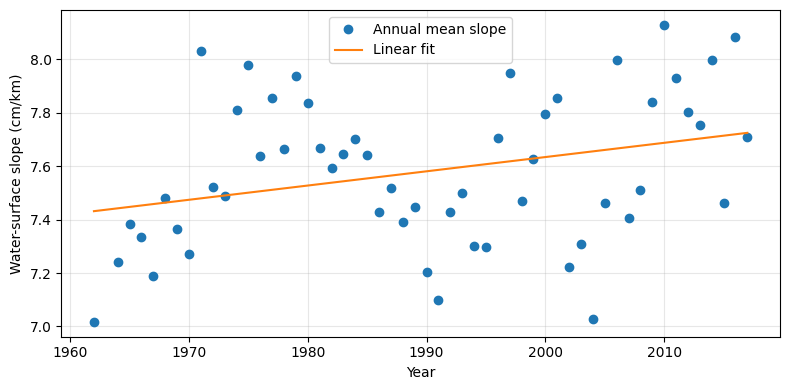

In [8]:
import matplotlib.pyplot as plt
from pathlib import Path

figdir = Path("../figs")
figdir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8,4))
plt.plot(x, y, 'o', label="Annual mean slope")
plt.plot(x, y_lin_pred, '-', label="Linear fit")

plt.xlabel("Year")
plt.ylabel("Water-surface slope (cm/km)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig(figdir/"annual_slope_linear_fit.png", dpi=300, bbox_inches="tight")
plt.savefig(figdir/"annual_slope_linear_fit.pdf", bbox_inches="tight") 

plt.show()


# 5a. Quadratic model plot

Quadratic model:
slope_cm_per_km = 4.924831e-05 * year^2 + -1.906726e-01 * year + 191.979


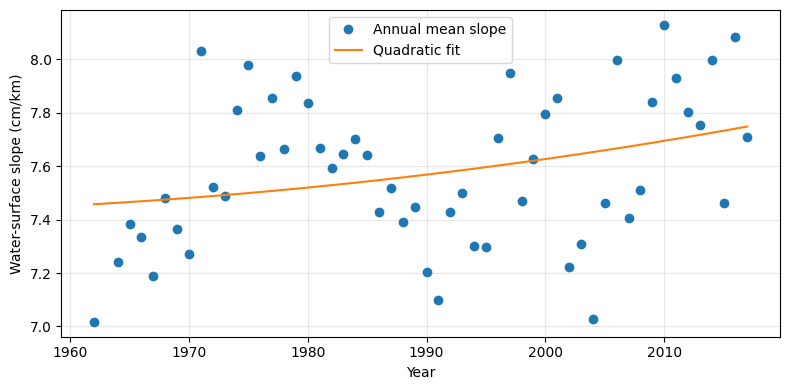

Saved: ../figs/slope_quadratic_fit.png
Saved: ../figs/slope_quadratic_fit.pdf


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# figs directory 
figdir = Path("../figs")
figdir.mkdir(parents=True, exist_ok=True)

# Quadratic model y = a*x^2 + b*x + c
deg_quad = 2
coef_quad = np.polyfit(x, y, deg_quad)
a_q, b_q, c_q = coef_quad
p_quad = np.poly1d(coef_quad)

x_fit = np.linspace(x.min(), x.max(), 300)
y_quad_fit = p_quad(x_fit)

print("Quadratic model:")
print(f"slope_cm_per_km = {a_q:.6e} * year^2 + {b_q:.6e} * year + {c_q:.3f}")

# Plot
plt.figure(figsize=(8,4))
plt.plot(x, y, 'o', label="Annual mean slope")
plt.plot(x_fit, y_quad_fit, '-', label="Quadratic fit")
plt.xlabel("Year")
plt.ylabel("Water-surface slope (cm/km)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Export (PNG + PDF)
out_png = figdir / "slope_quadratic_fit.png"
out_pdf = figdir / "slope_quadratic_fit.pdf"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.savefig(out_pdf, bbox_inches="tight")

plt.show()

print("Saved:", out_png)
print("Saved:", out_pdf)



# 5b. 5th-order polynomial model

5th-order polynomial model:
slope_cm_per_km = -5.733e-08*year^5 + 5.687e-04*year^4 + -2.256e+00*year^3 + 4.476e+03*year^2 + -4.439e+06*year + 1760883899.774


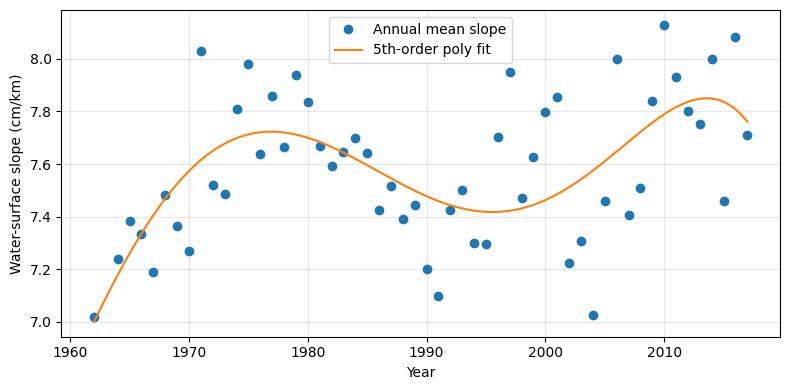

Saved: ../figs/slope_poly5_fit.png
Saved: ../figs/slope_poly5_fit.pdf


In [18]:
#  5th-order polynomial model y = a5*x^5 + a4*x^4 + a3*x^3 + a2*x^2 + a1*x + a0
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# figs directory
figdir = Path("../figs")
figdir.mkdir(parents=True, exist_ok=True)

# 5th-order polynomial model
deg_poly = 5
coef_poly = np.polyfit(x, y, deg_poly)
p_poly = np.poly1d(coef_poly)

a5, a4, a3, a2, a1, a0 = coef_poly
print("5th-order polynomial model:")
print(
    "slope_cm_per_km = "
    f"{a5:.3e}*year^5 + {a4:.3e}*year^4 + {a3:.3e}*year^3 + "
    f"{a2:.3e}*year^2 + {a1:.3e}*year + {a0:.3f}"
)

# Smooth curve for plotting
x_fit = np.linspace(x.min(), x.max(), 300)
y_poly_fit = p_poly(x_fit)

# Plot
plt.figure(figsize=(8,4))
plt.plot(x, y, 'o', label="Annual mean slope")
plt.plot(x_fit, y_poly_fit, '-', label="5th-order poly fit")
plt.xlabel("Year")
plt.ylabel("Water-surface slope (cm/km)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Export (PNG + PDF)
out_png = figdir / "slope_poly5_fit.png"
out_pdf = figdir / "slope_poly5_fit.pdf"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.savefig(out_pdf, bbox_inches="tight")

plt.show()

print("Saved:", out_png)
print("Saved:", out_pdf)


In [13]:
import numpy as np
import matplotlib.pyplot as plt



# Integer year for grouping
year_int = year_dec.astype(int)

# Unique years and annual mean slope
years_unique = np.unique(year_int)
annual_slope = np.array([
    slope_cm_per_km[year_int == y].mean() for y in years_unique
])

x = years_unique          # years
y = annual_slope          # annual mean slope (cm/km)


# 5c. Sinusoidal model

In [28]:
def fit_sine_fixed_T(x, y, T):
    """Fit y ≈ A sin(ωx) + B cos(ωx) + C with ω = 2π/T."""
    omega = 2 * np.pi / T

    # Design matrix G: columns are sin(ωx), cos(ωx), 1
    G = np.column_stack([
        np.sin(omega * x),
        np.cos(omega * x),
        np.ones_like(x)
    ])

    m, residuals, _, _ = np.linalg.lstsq(G, y, rcond=None)
    A, B, C = m

    y_pred = G @ m
    rss = np.sum((y - y_pred)**2)

    return A, B, C, omega, y_pred, rss


In [29]:
T_test = 20.0   # try 20-year cycle
A, B, C, omega, y_pred_test, rss_test = fit_sine_fixed_T(x, y, T_test)

print(f"Test T = {T_test:.1f} yrs  →  RSS = {rss_test:.3f}")
print(f"A = {A:.3f}, B = {B:.3f}, C = {C:.3f}")


Test T = 20.0 yrs  →  RSS = 3.608
A = -0.144, B = 0.047, C = 7.584


In [30]:
# Searching periods between 5 and 40 years 
T_grid = np.linspace(5.0, 40.0, 200)

best_rss = np.inf
best_params = None  # (A, B, C, omega, y_pred, rss, T)

for T in T_grid:
    A, B, C, omega, y_pred, rss = fit_sine_fixed_T(x, y, T)
    if rss < best_rss:
        best_rss = rss
        best_params = (A, B, C, omega, y_pred, rss, T)

A_best, B_best, omega_best, C_best = best_params[0], best_params[1], best_params[3], best_params[2]
y_pred_best = best_params[4]
T_best = best_params[6]

print(f"Best period T ≈ {T_best:.2f} years")
print(f"Best-fit model: y = A sin(ωx) + B cos(ωx) + C")
print(f"  A = {A_best:.3f}, B = {B_best:.3f}, C = {C_best:.3f}")
print(f"  ω = {omega_best:.4f} rad/yr  (RSS = {best_rss:.3f})")


Best period T ≈ 33.49 years
Best-fit model: y = A sin(ωx) + B cos(ωx) + C
  A = 0.089, B = 0.205, C = 7.558
  ω = 0.1876 rad/yr  (RSS = 2.885)


In [31]:
# Smooth x-grid for plotting
x_fit = np.linspace(x.min(), x.max(), 300)

# Evaluate the best-fit sine model on x_fit
y_fit = A_best*np.sin(omega_best*x_fit) + B_best*np.cos(omega_best*x_fit) + C_best


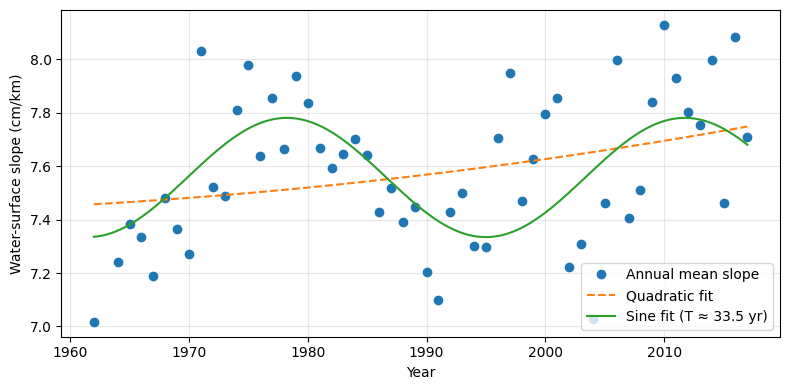

In [32]:

y_quad = p_quad(x_fit)

plt.figure(figsize=(8,4))
plt.plot(x, y, 'o', label='Annual mean slope')
plt.plot(x_fit, y_quad, '--', label='Quadratic fit')
plt.plot(x_fit, y_fit, '-', label=f'Sine fit (T ≈ {T_best:.1f} yr)')

plt.xlabel("Year")
plt.ylabel("Water-surface slope (cm/km)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# 6. Evaluating Sinusoidal, quadratic and 5th-order polynomial visually and Quantifying fit quality (RSS and WRSS)”

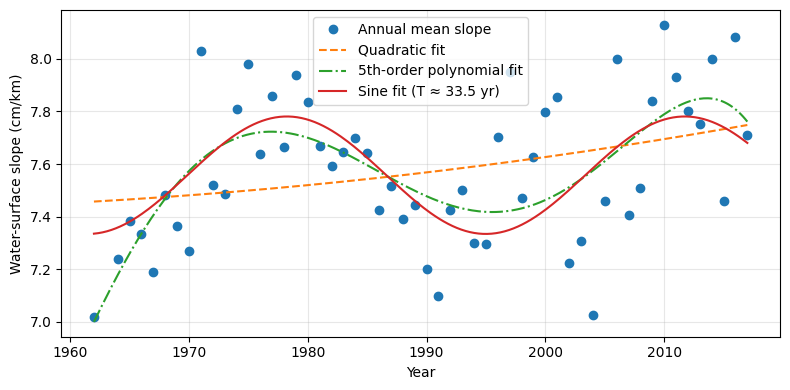

Saved: ../figs/slope_model_comparison.png
Saved: ../figs/slope_model_comparison.pdf


In [34]:
import matplotlib.pyplot as plt
from pathlib import Path

# figs folder
figdir = Path("../figs")
figdir.mkdir(parents=True, exist_ok=True)

p5 = p_poly   

# common grid
y_quad = p_quad(x_fit)
y_5    = p5(x_fit)

plt.figure(figsize=(8,4))

plt.plot(x, y, 'o', label="Annual mean slope")
plt.plot(x_fit, y_quad, '--', label="Quadratic fit")
plt.plot(x_fit, y_5, '-.', label="5th-order polynomial fit")
plt.plot(x_fit, y_fit, '-', label=f"Sine fit (T ≈ {T_best:.1f} yr)")

plt.xlabel("Year")
plt.ylabel("Water-surface slope (cm/km)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_png = figdir / "slope_model_comparison.png"
out_pdf = figdir / "slope_model_comparison.pdf"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.savefig(out_pdf, bbox_inches="tight")

plt.show()

print("Saved:", out_png)
print("Saved:", out_pdf)


In [38]:
import numpy as np

def fit_sine_fixed_T(x, y, T):
    omega = 2*np.pi / T
    G = np.column_stack([np.sin(omega*x), np.cos(omega*x), np.ones_like(x)])
    m, *_ = np.linalg.lstsq(G, y, rcond=None)
    A_sin, B_cos, C = m
    y_pred = G @ m
    rss = np.sum((y - y_pred)**2)
    return A_sin, B_cos, C, omega, y_pred, rss

# search period range
T_grid = np.linspace(5.0, 40.0, 200)

best = None
best_rss = np.inf

for T in T_grid:
    A_sin, B_cos, C, omega, y_pred, rss = fit_sine_fixed_T(x, y, T)
    if rss < best_rss:
        best_rss = rss
        best = (T, A_sin, B_cos, C, omega, y_pred)

T_best, A_sin, B_cos, C_best, omega_best, y_pred_best = best

# Convert (A_sin, B_cos) into amplitude 
A_best = np.sqrt(A_sin**2 + B_cos**2)             # amplitude
phi_best = np.arctan2(B_cos, A_sin) / omega_best  # phase in "years" 

print("Best-fit sine parameters (NumPy-only):")
print(f"A (amplitude) ≈ {A_best:.4f} cm/km")
print(f"phi (phase)   ≈ {phi_best:.2f} yr")
print(f"C (offset)    = {C_best:.4f} cm/km")
print(f"T (period)    ≈ {T_best:.2f} yr")
print(f"RSS           = {best_rss:.4f}")


Best-fit sine parameters (NumPy-only):
A (amplitude) ≈ 0.2231 cm/km
phi (phase)   ≈ 6.19 yr
C (offset)    = 7.5575 cm/km
T (period)    ≈ 33.49 yr
RSS           = 2.8848


In [41]:
omega_best = 2*np.pi / T_best

# model at data points
y_sine_data = A_sin*np.sin(omega_best*x) + B_cos*np.cos(omega_best*x) + C_best

# residuals
res_sine = y - y_sine_data

# RSS
RSS_sine = np.sum(res_sine**2)

# WRSS (here identical to RSS because sigma_y = 1)
sigma_y = np.ones_like(y)
WRSS_sine = np.sum((res_sine / sigma_y)**2)

print(f"RSS (sine)  = {RSS_sine:.4f}")
print(f"WRSS (sine) = {WRSS_sine:.4f}")


RSS (sine)  = 2.8848
WRSS (sine) = 2.8848


In [42]:
# model values at data years
y_quad_data = p_quad(x)
y_5_data    = p5(x)

res_quad = y - y_quad_data
res_5    = y - y_5_data

RSS_quad = np.sum(res_quad**2)
RSS_5    = np.sum(res_5**2)

print(f"RSS (quadratic)      = {RSS_quad:.4f}")
print(f"RSS (5th-order poly) = {RSS_5:.4f}")
print(f"RSS (sine)           = {RSS_sine:.4f}")


RSS (quadratic)      = 3.8562
RSS (5th-order poly) = 2.6152
RSS (sine)           = 2.8848
